### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import progressbar
import string

from Bio.Seq import Seq
from Bio.Alphabet import IUPAC

%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical, plot_model

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


#### Load & clean data

In [2]:
genomes = pd.read_csv('final_viral_genomes.csv')

genomes.rename(columns = {'Genome': 'Name'}, inplace = True)

genomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9460 entries, 0 to 9459
Data columns (total 17 columns):
Name                  9460 non-null object
Accession             9460 non-null object
Source information    5840 non-null object
Segm                  9460 non-null object
Length                9460 non-null object
Protein               9460 non-null object
Neighbors             9460 non-null object
Host                  9457 non-null object
Created               9460 non-null object
Updated               9460 non-null object
Classification        9460 non-null object
ItemId                9460 non-null object
SequenceType          9397 non-null object
Report                9460 non-null object
Sequence              9460 non-null object
Molecule Type         9460 non-null object
Phylogeny             9460 non-null object
dtypes: object(17)
memory usage: 1.2+ MB


In [3]:
# Clean up the length column and convert the values to ints
genomes['Length'] = genomes['Length'].apply(lambda x: int(x.replace('nt', '').replace('(', '').replace(')','')))

In [4]:
# Clean up the Phylogeny column a little bit
genomes['Phylogeny'] = genomes['Phylogeny'].apply(lambda x: x[9:-1] if x[-1] == ';' else x[9:])
genomes['Phylogeny'] = genomes['Phylogeny'].apply(lambda x: x.split(';')[1:] if len(x.split(';')) > 1 
                                                  else x.split(';'))
genomes['Phylogeny'] = genomes['Phylogeny'].apply(lambda x: ','.join(x))

genomes.tail()

,Name,Accession,Source information,Segm,Length,Protein,Neighbors,Host,Created,Updated,Classification,ItemId,SequenceType,Report,Sequence,Molecule Type,Phylogeny
9455,Wilkie partiti-like virus 1,/nuccore/1211677385,strain:mosWSCP36002,-,2100,1,-,invertebrates,06/27/2017,07/14/2017,unclassified viruses,NC_035122.1,complete genome,LOCUS NC_035122 2100 bp ...,tatactacaatatatacaatatttttcactcataaaatgactgact...,genomic RNA,unclassified viruses
9456,Wilkie partiti-like virus 2,/nuccore/1211677379,strain:mosWSCP53020,-,1819,1,1,eukaryotes,06/27/2017,07/14/2017,unclassified viruses,NC_035119.1,complete genome,LOCUS NC_035119 1819 bp ...,ggcaatatgaattcctatgcacttaacaacattattcgtacttcac...,genomic RNA,unclassified viruses
9457,Wolkberg virus segment 1,/nuccore/1197509331,isolate:2562_SA3,None,4461,proteins: 1,neighbors: 10,invertebrates,05/24/2017,05/24/2017,unclassified viruses,NC_034631.1,complete cds,LOCUS NC_034631 4461 bp ...,agtagtgtactaccaatattctaatattttcaatatatctttacaa...,genomic RNA,unclassified viruses
9458,Wolkberg virus segment 2,/nuccore/1197509335,isolate:2562_SA3,None,6873,proteins: 1,neighbors: 10,invertebrates,05/24/2017,05/24/2017,unclassified viruses,NC_034633.1,complete cds,LOCUS NC_034633 6873 bp ...,agtagtgtactcctatactaacttcacttatcactaaaatggacga...,genomic RNA,unclassified viruses
9459,Wolkberg virus segment 3,/nuccore/1197509333,isolate:2562_SA3,None,978,proteins: 1,neighbors: 10,invertebrates,05/24/2017,05/24/2017,unclassified viruses,NC_034632.1,complete cds,LOCUS NC_034632 978 bp ...,agtagtgtactccagaaaaaagacaataacaaatctcaatctacaa...,genomic RNA,unclassified viruses


In [5]:
# Clean up the SequenceType string, I just want every complete genome to have the same label so I can pick them out
def clean_sequence_type(string):
    string = str(string) 
                           
    if string == 'complete genome' or string == 'complete sequence' or 'complete genome' in string or 'complete sequence' in string or string == 'complate genome':
        return('complete genome')
    else:
        return(string)

genomes['SequenceType'] = genomes['SequenceType'].apply(clean_sequence_type)
genomes['SequenceType'].value_counts()

complete genome                                                                                                                               7293
complete cds                                                                                                                                  1414
error                                                                                                                                          202
hypothetical protein 2, and hypothetical protein 3 genes, complete cds                                                                          93
nan                                                                                                                                             63
segment                                                                                                                                         54
isolate                                                                                                               

In [6]:
# Check the different host values
genomes['Host'].value_counts()

bacteria                             2213
invertebrates                        2082
plants                               1965
vertebrates                          1318
vertebrates, human                    547
vertebrates, invertebrates, human     305
fungi                                 269
invertebrates, plants                 192
environment                           173
vertebrates, invertebrates            149
archaea                                89
algae                                  64
protozoa                               58
invertebrates, vertebrates              7
human                                   7
invertebrates, vertebrates, human       7
eukaryotes                              4
None                                    4
diatom                                  3
protozoa, vertebrates                   1
Name: Host, dtype: int64

In [7]:
# Turn the number of proteins into an int
genomes['Protein'] = genomes['Protein'].apply(lambda x: int(x) if x.isdigit() else np.nan)

In [8]:
# This function will translate a genome into a protein sequence to reduce size for 3 and 0 
# It works under the assumption that the DNA provided from the NCBI is the coding strand- 
#  which is equivalent to the RNA complement of the template strand, so I will not 
#  transcribe it. I will look into that assumption later when I get the chance
# note- the 'RNA' genomes are also listed in DNA format 
def translate_seq(seq):
    coding_dna = Seq(seq, IUPAC.unambiguous_dna)
    translation = coding_dna.translate()
    return(str(translation))

#test
print(translate_seq('atggccattgtaatgggccgctgaaagggtgcccgatag'))

#genomes['Translation'] = genomes['Sequence'].apply(translate_seq)

MAIVMGR*KGAR*


In [20]:
sample = genomes.loc[genomes['Name'] == 'Human immunodeficiency virus 1']
for seq in sample['Sequence']:
    print(len(seq))

9181


# Exploratory Data Analysis

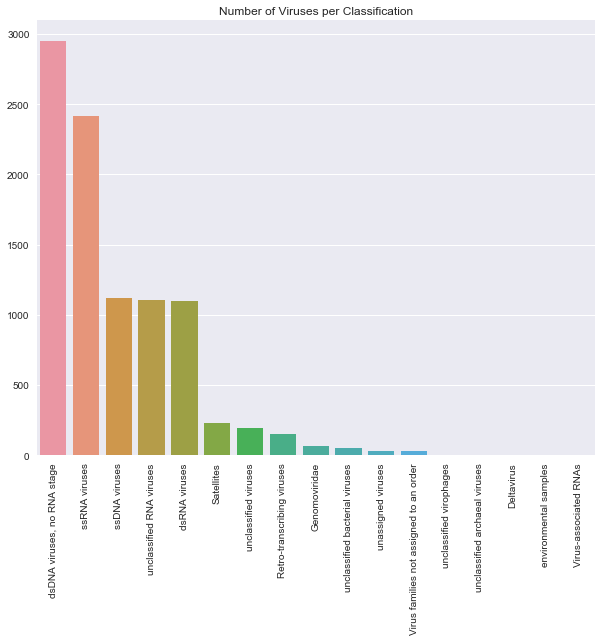

In [18]:
# Turn classifications and their counts into lists
classifications = [item[0] for item in list(genomes['Classification'].value_counts().items())]
class_counts = [item[1] for item in list(genomes['Classification'].value_counts().items())]

# Plot classifications and counts
plt.figure(figsize = (10,8))
virus_count_bar = sns.barplot(classifications, class_counts)
# Rotate x-axis ticklabels to make them legible
for item in virus_count_bar.get_xticklabels():
    item.set_rotation(90)
plt.title('Number of Viruses per Classification')
# Don't print the matplotlib plot text output
None

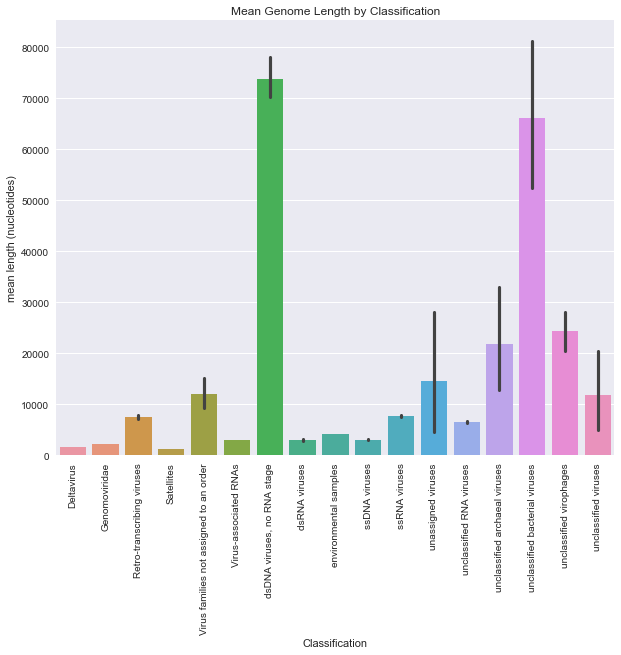

In [32]:
# Plot the mean genome length (and error bars) for each classification
plt.figure(figsize = (10,8))
class_length_bar = sns.barplot(genomes['Classification'], genomes['Length'])
for item in class_length_bar.get_xticklabels():
    item.set_rotation(90)
plt.title('Mean Genome Length by Classification')
plt.ylabel('mean length (nucleotides)')
None

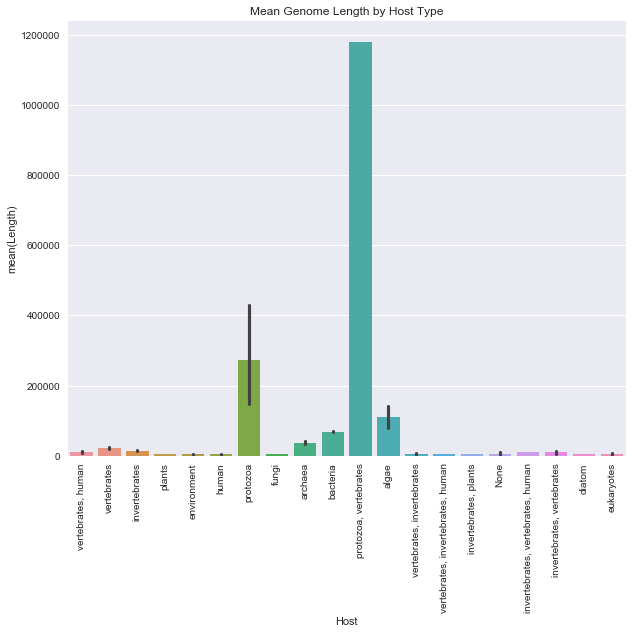

In [15]:
# Plot the mean genome length for each host type
plt.figure(figsize = (10,8))
type_length_bar = sns.barplot(genomes['Host'], genomes['Length'])
for item in type_length_bar.get_xticklabels():
    item.set_rotation(90)
plt.title('Mean Genome Length by Host Type')
None

In [20]:
genomes_h = genomes.loc[genomes['Host'] != 'protozoa, vertebrates']

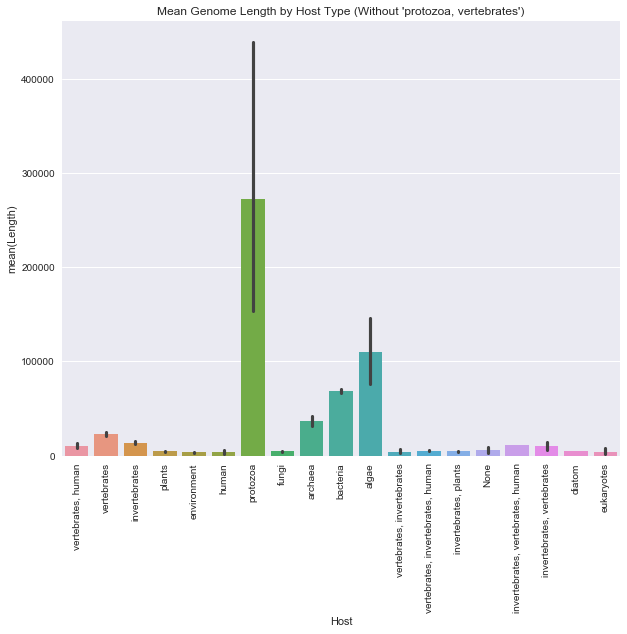

In [21]:
# Plot the mean genome length for each host type
plt.figure(figsize = (10,8))
type_length_bar = sns.barplot(genomes_h['Host'], genomes_h['Length'])
for item in type_length_bar.get_xticklabels():
    item.set_rotation(90)
plt.title("Mean Genome Length by Host Type (Without \'protozoa, vertebrates\')")
None

In [16]:
classifications

['dsDNA viruses, no RNA stage',
 'ssRNA viruses',
 'ssDNA viruses',
 'unclassified RNA viruses',
 'dsRNA viruses',
 'Satellites',
 'unclassified viruses',
 'Retro-transcribing viruses',
 'Genomoviridae',
 'unclassified bacterial viruses',
 'unassigned viruses',
 'Virus families not assigned to an order',
 'unclassified virophages',
 'unclassified archaeal viruses',
 'Deltavirus',
 'environmental samples',
 'Virus-associated RNAs']

Number per Phylogeny in unclassified RNA viruses 
 ['unclassified RNA viruses'] : [1105] 

Number per Phylogeny in unclassified viruses 
 ['unclassified viruses'] : [195] 

Number per Phylogeny in Retro-transcribing viruses 
 ['Retro'] : [151] 

Number per Phylogeny in unclassified virophages 
 ['unclassified virophages'] : [4] 

Number per Phylogeny in unclassified archaeal viruses 
 ['unclassified archaeal viruses'] : [4] 

Number per Phylogeny in Deltavirus 
 ['Deltavirus'] : [1] 

Number per Phylogeny in environmental samples 
 ['environmental samples'] : [1] 

Number per Phylogeny in Virus-associated RNAs 
 ['Virus'] : [1] 



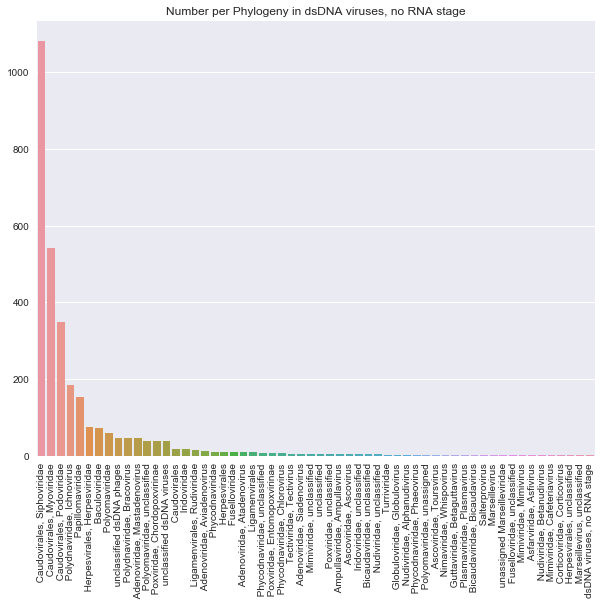

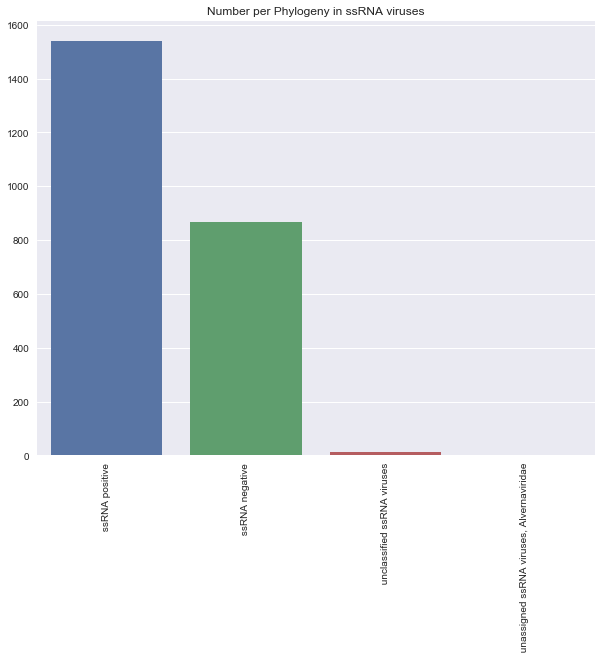

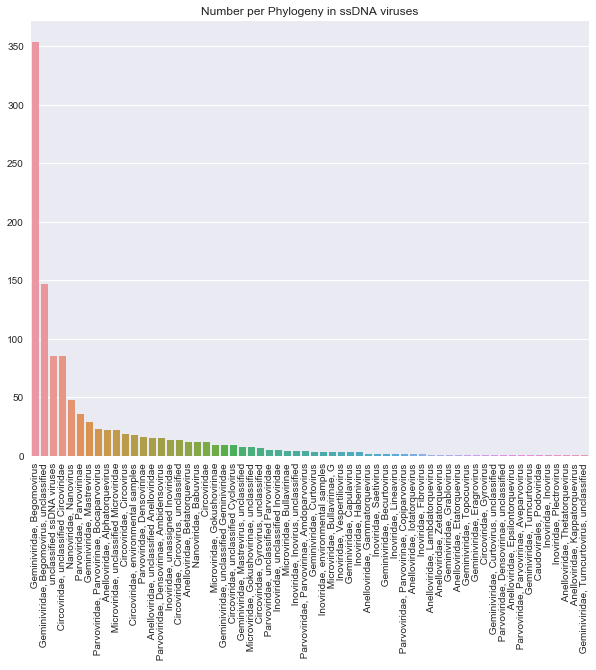

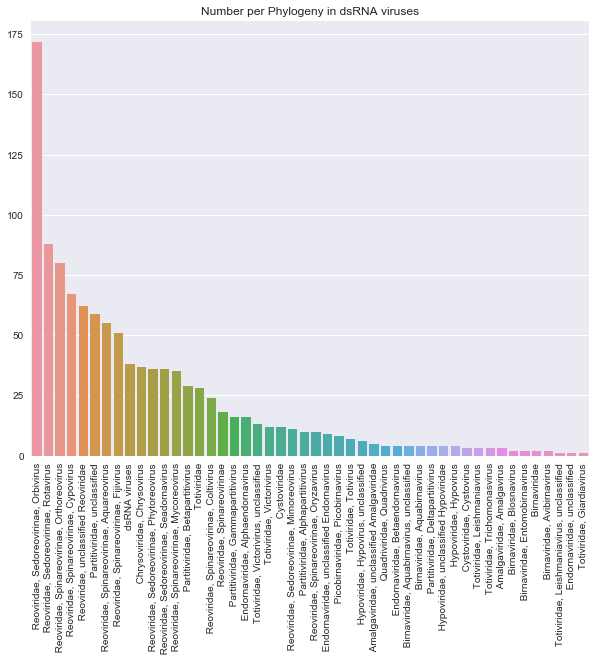

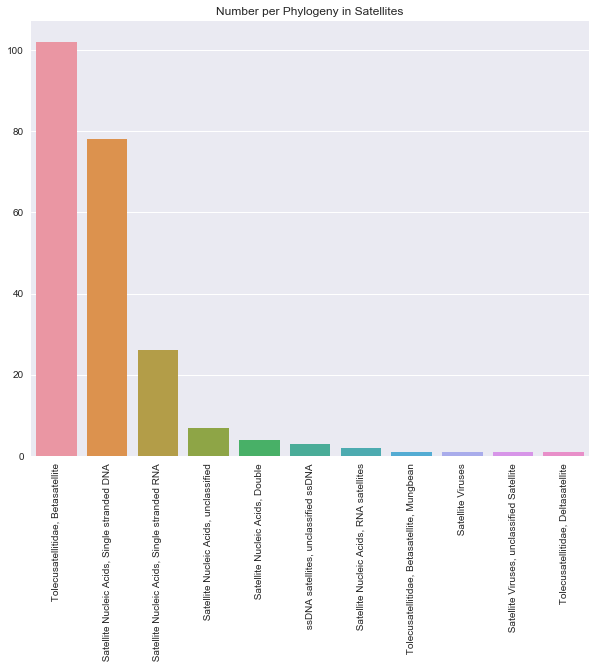

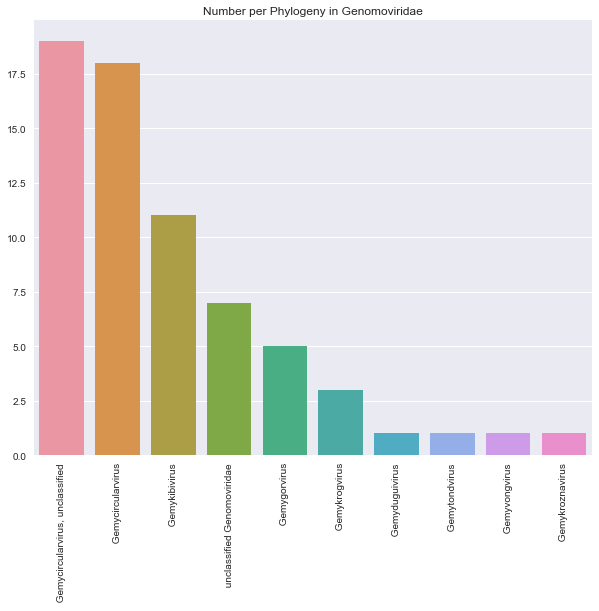

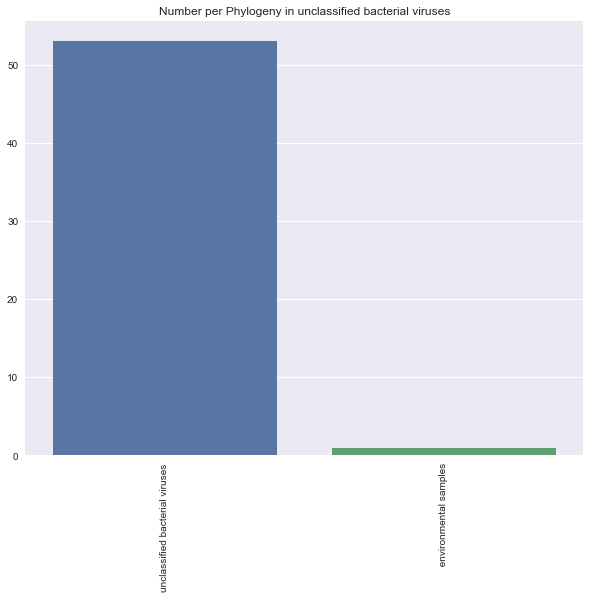

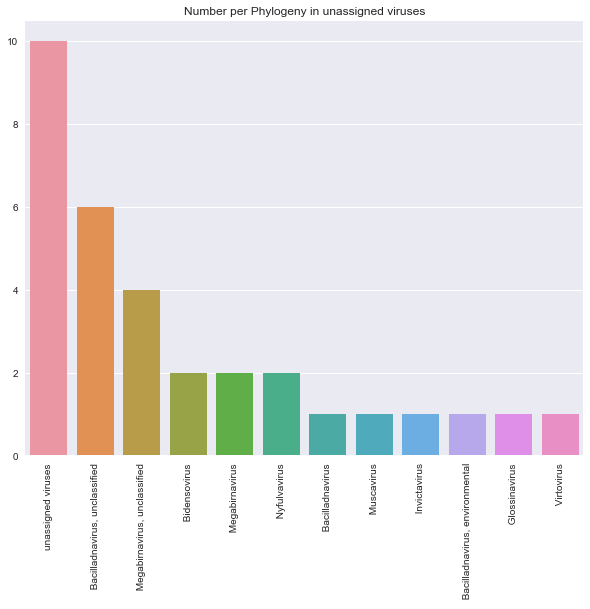

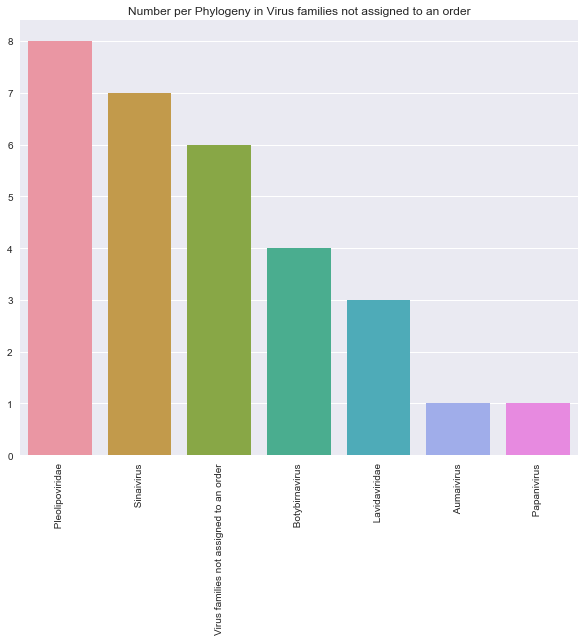

In [17]:
for classification in classifications:
    # For each classification, create a DataFrame with just that subset of the data, and create a list of 
    #  phylogenies and their respective counts 
    pd = genomes.loc[genomes['Classification'] == classification]
    phylogenies = [item[0] for item in list(pd['Phylogeny'].value_counts().items())]
    phylo_counts = [item[1] for item in list(pd['Phylogeny'].value_counts().items())]
    p_title = 'Number per Phylogeny in {}'.format(classification) 
    if len(phylogenies) > 1:
        # Plot phylogenies vs counts for each classification
        plt.figure(figsize = (10,8))
        phylo_count_bar = sns.barplot(phylogenies, phylo_counts)
        for item in phylo_count_bar.get_xticklabels():
            item.set_rotation(90)
        plt.title(p_title)
        None
    else: 
        # If there's only one count, print that, as opposed to a single bar on a barplot
        print(p_title, '\n', phylogenies,':', phylo_counts, '\n')

### Preprocessing Tools

In [13]:
# This function takes a series of sequences and matches them in length to the longest with 0s
def pad_seq_series(series):
    print('padding...')
    maximum = 0
    # Identify the length of the longest sequence in the series
    for seq in series:
        if len(seq) > maximum:
            maximum = len(seq)

    # This subfunction adds as many 0s as necessary to a sequence to make it as long as the longest one
    def pad_seq(seq, max_length):
        num_padding = max_length - len(seq)
        new_seq = seq + (num_padding * '0')
        return(new_seq)
    
    # Apply the pad_seq function to each sequence in the series
    padded_series = series.apply(pad_seq, max_length = maximum)
    print('done')
    return(padded_series)

# This function takes a series of sequences and returns an array of the encoded variables in that series
def encode_seq_series(series):
    print('encoding sequences...')
    def nt_numerical(nt): 
        # Return numerical variables for each nucleotide in the sequence
        #  See citation below for an explanation of these variables and alternatives
        if nt == 'a':
            return(-1.5)
        elif nt == 't':
            return(1.5)
        elif nt == 'c':
            return(0.5)
        elif nt == 'g':
            return(-0.5)
        else:
            return(nt)
    
    genome_list = []
    i = 0
    # For some reason I can't figure out just yet, this function prints out a bar to 3 percent on the testing set (X1)
    #  before actually carrying out the function, which starts with the print statement. This is weird but doesn't 
    #  impact the functionality of the function and I like having the progressbar on the longer transformations
    with progressbar.ProgressBar(max_value = len(series)) as bar:
        for seq in series:
            # For each sequence, turn the string into a list of characterss, apply the function above to each char, 
            #  and add the resulting list to the genome_list
            seq_list = list(seq)
            mapped_list = list(map(nt_numerical, seq_list))
            genome_list.append(mapped_list)
            i += 1
            bar.update(i)
    
    print('done')
    return(np.array(genome_list))

## Encoding variables are from:
# Keung Kwan, Hon & Arniker, Swarna. (2009). Numerical representation of DNA sequences. 
# 307 - 310. 10.1109/EIT.2009.5189632. 

In [14]:
# This function takes a series of sequences and returns an array of the encoded variables in that series
def encode_translated_series(series):
    print('encoding proteins...')
    
# Return numerical variables 1-27 for each amino acid (0 is for padding)
    alphabet = list(string.ascii_uppercase)
    alphabet.append('*')
    alpha_vals = {}
    for val, letter in enumerate(alphabet):
        alpha_vals[letter] = val+1

    def amino_numerical(am):
        if am in alphabet:
            return(alpha_vals[am])
        else:
            return(am)

## code below copied from function above   
    genome_list = []
    i = 0
    with progressbar.ProgressBar(max_value = len(series)) as bar:
        for seq in series:
            # For each sequence, turn the string into a list of characterss, apply the function above to each char, 
            #  and add the resulting list to the genome_list
            seq_list = list(seq)
            mapped_list = list(map(amino_numerical, seq_list))
            genome_list.append(mapped_list)
            i += 1
            bar.update(i)
    
    print('done')
    return(np.array(genome_list))

# Modelling

note: each virus classification's dataframe and associated variables/models below is numbered, but this numbering is arbitrary and corresponds to the order I worked through them in. This numbering avoids typos and titles that look too similar.
also: models 1-4 and both preprocessing and model 5 are run and further optimized in .py runs on EC2, so the code below is only the framework for some of these models, and updated/optimized models will be found in the repo. 

## ssDNA viruses

In [14]:
# Gather only the complete genomes for ssDNA viruses
genomes_1 = genomes.loc[genomes['Classification'] == 'ssDNA viruses'][['Name', 'Phylogeny', 'Sequence', 'SequenceType']].copy()
genomes_1 = genomes_1.loc[genomes['SequenceType'] == 'complete genome'][['Name', 'Phylogeny', 'Sequence']]

# Set a target variable: 1 if a virus is in the 'Geminiviridae' family, otherwise 0
genomes_1['target'] = genomes_1['Phylogeny'].apply(lambda x: 1 if 'Geminiviridae' in x else 0)
print(genomes_1['target'].value_counts())

genomes_1.head()

1    541
0    533
Name: target, dtype: int64


,Name,Phylogeny,Sequence,target
4528,Abaca bunchy top virus segment 1,"Nanoviridae, Babuvirus",ggggctggggcttattattacccccagccccggaacgggacatcac...,0
4529,Abaca bunchy top virus segment 2,"Nanoviridae, Babuvirus",ggcaggggggcttattattaccccccctgcccgggacgggacatca...,0
4530,Abaca bunchy top virus segment 3,"Nanoviridae, Babuvirus",agcaggggggcttattattaccccccctgctcggggcgggacattc...,0
4531,Abaca bunchy top virus segment 4,"Nanoviridae, Babuvirus",ggcaggggggcttattattaccccccctgcccgggacgggacattt...,0
4532,Abaca bunchy top virus segment 5,"Nanoviridae, Babuvirus",agcaggggggcttattattaccccccctgctgggacgggacatccg...,0


In [19]:
# Calculate and print a baseline 
targets = [item[1] for item in list(genomes_1['target'].value_counts().items())]
baseline = max(targets)/sum(targets)
print('Baseline: {}%'.format(str(np.round(baseline, 4)*100)))

Baseline: 50.37%


In [20]:
# Pad and encode the series of sequences
X1 = genomes_1['Sequence']
X1 = pad_seq_series(X1)
X1 = encode_seq_series(X1)
y1 = to_categorical(genomes_1['target'])
X1

padding...
done
encoding...


100% (1074 of 1074) |###################################################################################################################################################################################| Elapsed Time: 0:00:02 Time: 0:00:02

done


array([['-0.5', '-0.5', '-0.5', ..., '0', '0', '0'],
       ['-0.5', '-0.5', '0.5', ..., '0', '0', '0'],
       ['-1.5', '-0.5', '0.5', ..., '0', '0', '0'],
       ..., 
       ['-1.5', '0.5', '0.5', ..., '0', '0', '0'],
       ['-1.5', '-1.5', '-1.5', ..., '0', '0', '0'],
       ['-1.5', '-1.5', '-0.5', ..., '0', '0', '0']], 
      dtype='<U32')

In [26]:
# Save the arrays
np.save('/models/X1_genome_array', X1)
np.save('/models/y1_genome_array', y1)

In [29]:
# Set up the target variable and train_test_split, with an equal proportion of target variables in test/train
X1 = np.load('X1_genome_array.npy')
y1 = np.load('y1_genome_array.npy')

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.33, stratify = y1)

# Reshape the input variables to make them 3D
X1_train = X1_train.reshape(X1_train.shape[0],1,len(X1[0]),1)
X1_test = X1_test.reshape(X1_test.shape[0],1,len(X1[0]),1)

# Check the shape
X1_train.shape

(719, 1, 11702, 1)

In [31]:
# CNN to classify ssDNA viruses (1)
model_1 = Sequential()
model_1.add(Conv2D(50, kernel_size =(1,100), input_shape=(X1_train.shape[1:]), activation='relu'))
model_1.add(MaxPool2D((1, 5)))
model_1.add(Conv2D(40, (1,100), activation='relu'))
model_1.add(MaxPool2D((1, 4)))
model_1.add(Conv2D(30, (1,100), activation='relu'))
model_1.add(MaxPool2D((1, 3)))
model_1.add(Conv2D(20, (1,100), activation='relu'))
model_1.add(MaxPool2D((1, 2)))
model_1.add(Flatten())
model_1.add(Dense(50, activation='relu'))
model_1.add(Dense(y1.shape[1], activation='sigmoid'))

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_1.fit(X1_train, y1_train, validation_data = (X1_test, y1_test), epochs = 1)

Train on 719 samples, validate on 355 samples
Epoch 1/1
719/719 [==============================] - 57s 80ms/step - loss: 0.3583 - acc: 0.8526 - val_loss: 0.2976 - val_acc: 0.9211


Try this model with the translated sequence, to see if the translated sequence will work for 3 and 0

In [13]:
# Gather only the complete genomes for ssDNA viruses
genomes_1b = genomes.loc[genomes['Classification'] == 'ssDNA viruses'][['Name', 'Phylogeny', 'Translation', 'SequenceType']].copy()
genomes_1b = genomes_1b.loc[genomes['SequenceType'] == 'complete genome'][['Name', 'Phylogeny', 'Translation']]

# Set a target variable: 1 if a virus is in the 'Geminiviridae' family, otherwise 0
genomes_1b['target'] = genomes_1b['Phylogeny'].apply(lambda x: 1 if 'Geminiviridae' in x else 0)
print(genomes_1b['target'].value_counts())

genomes_1b.head()

1    541
0    533
Name: target, dtype: int64


,Name,Phylogeny,Translation,target
4528,Abaca bunchy top virus segment 1,"Nanoviridae, Babuvirus",GAGAYYYPQPRNGTSRASLYTHVTSNGLLAR*KGFLRKPGIIYGL*...,0
4529,Abaca bunchy top virus segment 2,"Nanoviridae, Babuvirus",GRGAYYYPPCPGRDITCAYKEARDDVTYVCRKLYKSECFIALFVA*...,0
4530,Abaca bunchy top virus segment 3,"Nanoviridae, Babuvirus",SRGAYYYPPCSGRDIL*WAGLYAAK*AHKARSGPI*GPVV*KCRVP...,0
4531,Abaca bunchy top virus segment 4,"Nanoviridae, Babuvirus",GRGAYYYPPCPGRDICIYK*KRPRSTRSGAAMARYVVCWMFTINNP...,0
4532,Abaca bunchy top virus segment 5,"Nanoviridae, Babuvirus",SRGAYYYPPCWDGTSE**WA*YINGPPNKRTVQYLRFGPRPKIKRT...,0


In [15]:
# Pad and encode the series of sequences
X1b = genomes_1b['Translation']
X1b = pad_seq_series(X1b)
X1b = encode_translated_series(X1b)
y1b = to_categorical(genomes_1b['target'])
X1b

padding...
done
encoding proteins...


100% (1074 of 1074) |#####################| Elapsed Time: 0:00:02 ETA:  0:00:00

done


100% (1074 of 1074) |#####################| Elapsed Time: 0:00:02 Time: 0:00:02


array([['7', '1', '7', ..., '0', '0', '0'],
       ['7', '18', '7', ..., '0', '0', '0'],
       ['19', '18', '7', ..., '0', '0', '0'],
       ..., 
       ['20', '7', '4', ..., '0', '0', '0'],
       ['11', '11', '22', ..., '0', '0', '0'],
       ['11', '6', '27', ..., '0', '0', '0']], 
      dtype='<U21')

In [16]:
X1b_train, X1b_test, y1b_train, y1b_test = train_test_split(X1b, y1b, test_size = 0.33, stratify = y1b)

# Reshape the input variables to make them 3D
X1b_train = X1b_train.reshape(X1b_train.shape[0],1,len(X1b[0]),1)
X1b_test = X1b_test.reshape(X1b_test.shape[0],1,len(X1b[0]),1)

# Check the shape
X1b_train.shape

(719, 1, 3900, 1)

In [19]:
# CNN to classify ssDNA viruses based on translated sequence (1b)
model_1b = Sequential()
model_1b.add(Conv2D(50, kernel_size =(1,100), input_shape=(X1b_train.shape[1:]), activation='relu'))
model_1b.add(MaxPool2D((1, 5)))
model_1b.add(Conv2D(40, (1,100), activation='relu'))
model_1b.add(MaxPool2D((1, 4)))
model_1b.add(Conv2D(30, (1,100), activation='relu'))
model_1b.add(MaxPool2D((1, 3)))
model_1b.add(Conv2D(20, (1,20), activation='relu'))
model_1b.add(MaxPool2D((1, 2)))
model_1b.add(Flatten())
model_1b.add(Dense(50, activation='relu'))
model_1b.add(Dense(y1b.shape[1], activation='sigmoid'))

model_1b.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_1b.fit(X1b_train, y1b_train, validation_data = (X1b_test, y1b_test), epochs = 10)

Train on 719 samples, validate on 355 samples
Epoch 1/10
719/719 [==============================] - 18s 24ms/step - loss: 0.4525 - acc: 0.6551 - val_loss: 0.4977 - val_acc: 0.4986
Epoch 2/10
719/719 [==============================] - 16s 22ms/step - loss: 0.4407 - acc: 0.4979 - val_loss: 0.5220 - val_acc: 0.4986
Epoch 3/10
719/719 [==============================] - 16s 22ms/step - loss: 0.4043 - acc: 0.4979 - val_loss: 0.4957 - val_acc: 0.4986
Epoch 4/10
719/719 [==============================] - 16s 22ms/step - loss: 0.4445 - acc: 0.5327 - val_loss: 0.4673 - val_acc: 0.6113
Epoch 5/10
719/719 [==============================] - 16s 22ms/step - loss: 0.4231 - acc: 0.7149 - val_loss: 0.4325 - val_acc: 0.5577
Epoch 6/10
719/719 [==============================] - 16s 22ms/step - loss: 0.4161 - acc: 0.4993 - val_loss: 0.4890 - val_acc: 0.4986
Epoch 7/10
719/719 [==============================] - 16s 22ms/step - loss: 0.4197 - acc: 0.4979 - val_loss: 0.5479 - val_acc: 0.4986
Epoch 8/10
719/7

## ssRNA viruses

In [33]:
# complete genomes for ssRNA viruses
genomes_2 = genomes.loc[genomes['Classification'] == 'ssRNA viruses'][['Name', 'Phylogeny', 'Sequence', 'SequenceType']].copy()
genomes_2 = genomes_2.loc[genomes['SequenceType'] == 'complete genome'][['Name', 'Phylogeny', 'Sequence']]

genomes_2['target'] = genomes_2['Phylogeny'].apply(lambda x: 1 if 'positive' in x else 0)
print(genomes_2['target'].value_counts())

genomes_2.head()

1    1289
0     557
Name: target, dtype: int64


,Name,Phylogeny,Sequence,target
5648,Achimota virus 1,ssRNA negative,accagagggaaaatataacaatgtcgttttatagcgatgtaaataa...,0
5649,Achimota virus 2,ssRNA negative,accagagggaaaattaagaaaggtcgttccaagacgacttaaaaga...,0
5650,Acinetobacter phage AP205,ssRNA positive,ggagtgaaccccggagggggttcgctgaaagccgaatcgaattcga...,1
5651,Aconitum latent virus,ssRNA positive,cgaaaaactgaacatacaatatcctgacatacacagaagtacacta...,1
5652,Actinidia virus 1,ssRNA positive,aaccataacggcaattatttcgcagatttcatttgctgttgtataa...,1


In [34]:
# Save to a file to be imported by the .py version in EC2
genomes_2.to_csv('genomes_2.csv', index = False)

genomes_2 = pd.read_csv('genomes_2.csv')

genomes_2.head()

,Name,Phylogeny,Sequence,target
0,Achimota virus 1,ssRNA negative,accagagggaaaatataacaatgtcgttttatagcgatgtaaataa...,0
1,Achimota virus 2,ssRNA negative,accagagggaaaattaagaaaggtcgttccaagacgacttaaaaga...,0
2,Acinetobacter phage AP205,ssRNA positive,ggagtgaaccccggagggggttcgctgaaagccgaatcgaattcga...,1
3,Aconitum latent virus,ssRNA positive,cgaaaaactgaacatacaatatcctgacatacacagaagtacacta...,1
4,Actinidia virus 1,ssRNA positive,aaccataacggcaattatttcgcagatttcatttgctgttgtataa...,1


In [35]:
# Calculate and print a baseline 
targets = [item[1] for item in list(genomes_2['target'].value_counts().items())]
baseline = max(targets)/sum(targets)
print('Baseline: {}%'.format(str(np.round(baseline, 4)*100)))

Baseline: 69.83%


In [36]:
X2 = genomes_2['Sequence']
X2 = pad_seq_series(X2)
X2 = encode_seq_series(X2)
y2 = to_categorical(genomes_2['target'])
X2

padding...
done
encoding...


100% (1846 of 1846) |###################################################################################################################################################################################| Elapsed Time: 0:00:13 Time: 0:00:13

done


array([['-1.5', '0.5', '0.5', ..., '0', '0', '0'],
       ['-1.5', '0.5', '0.5', ..., '0', '0', '0'],
       ['-0.5', '-0.5', '-1.5', ..., '0', '0', '0'],
       ..., 
       ['-1.5', '-1.5', '-1.5', ..., '0', '0', '0'],
       ['-1.5', '-1.5', '-1.5', ..., '0', '0', '0'],
       ['-0.5', '-1.5', '-1.5', ..., '0', '0', '0']], 
      dtype='<U32')

In [37]:
# Save the arrays
np.save('/models/X2_genome_array', X2)
np.save('/models/y2_genome_array', y2)

In [23]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.33, stratify = y2)

X2_train = X2_train.reshape(X2_train.shape[0],1,len(X2[0]),1)
X2_test = X2_test.reshape(X2_test.shape[0],1,len(X2[0]),1)

X2_train.shape

(1236, 1, 33452, 1)

In [25]:
# CNN to classify ssRNA viruses (2)
model_2 = Sequential()
model_2.add(Conv2D(50, kernel_size =(1,100), input_shape=(X2_train.shape[1:]), activation='relu'))
model_2.add(MaxPool2D((1, 5)))
model_2.add(Conv2D(40, (1,100), activation='relu'))
model_2.add(MaxPool2D((1, 4)))
model_2.add(Conv2D(30, (1,100), activation='relu'))
model_2.add(MaxPool2D((1, 3)))
model_2.add(Conv2D(20, (1,100), activation='relu'))
model_2.add(MaxPool2D((1, 2)))
model_2.add(Flatten())
model_2.add(Dense(50, activation='relu'))
model_2.add(Dense(y2.shape[1], activation='sigmoid'))

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_2.fit(X2_train, y2_train, validation_data = (X2_test, y2_test), epochs = 3)

Train on 1236 samples, validate on 610 samples
Epoch 1/3
1236/1236 [==============================] - 214s - loss: 0.7204 - acc: 0.3430 - val_loss: 0.6904 - val_acc: 0.3000
Epoch 2/3
1236/1236 [==============================] - 213s - loss: 0.7409 - acc: 0.3042 - val_loss: 0.6873 - val_acc: 0.3000
Epoch 3/3
1236/1236 [==============================] - 214s - loss: 0.7767 - acc: 0.3042 - val_loss: 0.6874 - val_acc: 0.3000


## dsDNA viruses with no RNA stage 

In [13]:
# dsDNA viruses with no RNA stage, which would make for a clunky dataframe name
# this dataframe will include only complete genomes
genomes_3 = genomes.loc[genomes['Classification'] == 'dsDNA viruses, no RNA stage'][['Name', 'Phylogeny', 'Sequence', 'Length', 'SequenceType']].copy()
genomes_3 = genomes_3.loc[genomes['SequenceType'] == 'complete genome'][['Name', 'Phylogeny', 'Sequence', 'Length']]

genomes_3['target'] = genomes_3['Phylogeny'].apply(lambda x: 1 if 'Siphoviridae' in x else 0)
genomes_3['target'].value_counts()

genomes_3.head()

,Name,Phylogeny,Sequence,Length,target
476,Abalone herpesvirus Victoria/AUS/2009,"Herpesvirales, unclassified",actcgtatgaactttgactggtttttggggcgcgagagtttggttt...,211518,0
477,Abalone shriveling syndrome-associated virus,unclassified dsDNA viruses,ctatttaactaatttagtattgtttgttgttttcggttgagtcaat...,34952,0
478,Acanthamoeba polyphaga mimivirus,"Mimiviridae, Mimivirus",cgccgggggttgacggcggggctgggaaacccattgaaatttccgt...,1181549,0
479,Acanthamoeba polyphaga moumouvirus,"Mimiviridae, unclassified",gaataataataatttttatttatttttacgggttttattgtttcca...,1021348,0
480,Acanthocystis turfacea Chlorella virus 1,"Phycodnaviridae, Chlorovirus",ttgctctgtctgcttgcattttgaagatttgccattgtcccgacat...,288047,0


In [21]:
genomes_3['Length'].median()

45858.0

In [22]:
genomes_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2787 entries, 476 to 3425
Data columns (total 5 columns):
Name         2787 non-null object
Phylogeny    2787 non-null object
Sequence     2787 non-null object
Length       2787 non-null int64
target       2787 non-null int64
dtypes: int64(2), object(3)
memory usage: 130.6+ KB


In [18]:
genomes_3 = genomes_3.loc[genomes_3['Length'] < 100000]
genomes_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2141 entries, 477 to 3425
Data columns (total 5 columns):
Name         2141 non-null object
Phylogeny    2141 non-null object
Sequence     2141 non-null object
Length       2141 non-null int64
target       2141 non-null int64
dtypes: int64(2), object(3)
memory usage: 100.4+ KB


In [15]:
# Calculate and print a baseline 
targets = [item[1] for item in list(genomes_3['target'].value_counts().items())]
baseline = max(targets)/sum(targets)
print('Baseline: {}%'.format(str(np.round(baseline, 4)*100)))

Baseline: 52.73%


In [17]:
genomes_3.to_csv('genomes_3.csv', index = False)

In [16]:
# Pad and encode the series of sequences
X3 = genomes_3['Sequence']
X3 = pad_seq_series(X3)
X3 = encode_seq_series(X3)
print('encoding y...')
y3 = to_categorical(genomes_3['target'])
print('done')

padding...
done
encoding sequences...


100% (2141 of 2141) |##################################################################| Elapsed Time: 0:00:41 ETA:  0:00:00

done


100% (2141 of 2141) |##################################################################| Elapsed Time: 0:00:41 Time: 0:00:41


KeyboardInterrupt: 

In [ ]:
# Save the arrays
np.save('/models/X3_genome_array', X3)
np.save('/models/y3_genome_array', y3)

In [ ]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.33, stratify = y3)

X3_train = X3_train.values.reshape(X3_train.shape[0], 1, 1)
X3_test = X3_test.values.reshape(X3_test.shape[0], 1, 1)

X3.shape

In [ ]:
model_3 = Sequential()
model_3.add(Conv2D(50, kernel_size =(1,100), input_shape=(X3_train.shape[1:]), activation='relu'))
model_3.add(MaxPool2D((1, 5)))
model_3.add(Conv2D(40, (1,100), activation='relu'))
model_3.add(MaxPool2D((1, 4)))
model_3.add(Conv2D(30, (1,100), activation='relu'))
model_3.add(MaxPool2D((1, 3)))
model_3.add(Conv2D(20, (1,100), activation='relu'))
model_3.add(MaxPool2D((1, 2)))
model_3.add(Flatten())
model_3.add(Dense(50, activation='relu'))
model_3.add(Dense(y3.shape[1], activation='sigmoid'))

model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_3.fit(X3_train, y3_train, validation_data = (X3_test, y3_test), epochs = 10)

## dsRNA viruses

In [10]:
genomes_4 = genomes.loc[genomes['Classification'] == 'dsRNA viruses'][['Name', 'Phylogeny', 'Sequence', 'SequenceType']].copy()
genomes_4 = genomes_4.loc[genomes['SequenceType'] == 'complete genome'][['Name', 'Phylogeny', 'Sequence']]

genomes_4['target'] = genomes_4['Phylogeny'].apply(lambda x: 1 if 'Sedoreovirinae' in x else 0)
print(genomes_4['target'].value_counts())

genomes_4.head()

0    648
1    269
Name: target, dtype: int64


,Name,Phylogeny,Sequence,target
3426,Adult diarrheal rotavirus strain J19 segment 1,"Reoviridae, Sedoreovirinae, Rotavirus",ggcacttaatggctaagttaattataatcaacagtgagaaaggcga...,1
3427,Adult diarrheal rotavirus strain J19 segment 2,"Reoviridae, Sedoreovirinae, Rotavirus",ggcaatttgaagccatgttgctctttattattctatctgttggcgt...,1
3428,Adult diarrheal rotavirus strain J19 segment 3,"Reoviridae, Sedoreovirinae, Rotavirus",ggaacttaaaacatcaatcgttgctgcaacagcggttggttacctc...,1
3429,Adult diarrheal rotavirus strain J19 segment 4,"Reoviridae, Sedoreovirinae, Rotavirus",ggcaatttcttgctacaagtgactgtgaaggatggatctgattgag...,1
3430,Adult diarrheal rotavirus strain J19 segment 5,"Reoviridae, Sedoreovirinae, Rotavirus",ggcattttgttcatcacaaatcacgatggaaggaactagtgaaagt...,1


In [11]:
# Calculate and print a baseline 
targets = [item[1] for item in list(genomes_4['target'].value_counts().items())]
baseline = max(targets)/sum(targets)
print('Baseline: {}%'.format(str(np.round(baseline, 4)*100)))

Baseline: 70.67%


In [15]:
# Pad and encode the series of sequences
X4 = genomes_4['Sequence']
X4 = pad_seq_series(X4)
X4 = encode_seq_series(X4)
y4 = to_categorical(genomes_4['target'])
X4

padding...
done
encoding sequences...


100% (917 of 917) |#######################| Elapsed Time: 0:00:09 ETA:  0:00:00

done


100% (917 of 917) |#######################| Elapsed Time: 0:00:09 Time: 0:00:09


array([['-0.5', '-0.5', '0.5', ..., '0', '0', '0'],
       ['-0.5', '-0.5', '0.5', ..., '0', '0', '0'],
       ['-0.5', '-0.5', '-1.5', ..., '0', '0', '0'],
       ..., 
       ['-0.5', '1.5', '1.5', ..., '0', '0', '0'],
       ['-0.5', '0.5', '-1.5', ..., '0', '0', '0'],
       ['-0.5', '1.5', '-1.5', ..., '0', '0', '0']], 
      dtype='<U32')

In [41]:
# Save the arrays
np.save('/models/X4_genome_array', X4)
np.save('/models/y4_genome_array', y4)

In [16]:
# Set up the target variable and train_test_split, with an equal proportion of target variables in test/train
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size = 0.33, stratify = y4)

# Reshape the input variables to make them 3D
X4_train = X4_train.reshape(X4_train.shape[0],1,len(X4[0]),1)
X4_test = X4_test.reshape(X4_test.shape[0],1,len(X4[0]),1)

# Check the shape
X4_train.shape

(614, 1, 22781, 1)

In [17]:
# CNN to classify dsRNA viruses (4)
model_4 = Sequential()
model_4.add(Conv2D(50, kernel_size =(1,200), input_shape=(X4_train.shape[1:]), activation='relu'))
model_4.add(MaxPool2D((1, 5)))
model_4.add(Conv2D(40, (1,200), activation='relu'))
model_4.add(MaxPool2D((1, 4)))
model_4.add(Conv2D(30, (1,200), activation='relu'))
model_4.add(MaxPool2D((1, 3)))
model_4.add(Conv2D(20, (1,200), activation='relu'))
model_4.add(MaxPool2D((1, 2)))
model_4.add(Flatten())
model_4.add(Dense(50, activation='relu'))
model_4.add(Dense(y4.shape[1], activation='sigmoid'))

model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_4.fit(X4_train, y4_train, validation_data = (X4_test, y4_test), epochs = 1)

Train on 614 samples, validate on 303 samples
Epoch 1/1
614/614 [==============================] - 315s 512ms/step - loss: 0.5643 - acc: 0.6971 - val_loss: 0.5860 - val_acc: 0.6931


## Virus Classifier

In [61]:
# Get the full genomes for the virus classifications above 
genomes_01 = genomes.loc[genomes['Classification'] == 'ssDNA viruses'][['Name', 'Sequence', 'SequenceType', 
                                                                        'Classification', 'Length']] 
genomes_02 = genomes.loc[genomes['Classification'] == 'ssRNA viruses'][['Name', 'Sequence', 'SequenceType', 
                                                                        'Classification', 'Length']]
genomes_03 = genomes.loc[genomes['Classification'] == 'dsDNA viruses, no RNA stage'][['Name', 'Sequence', 
                                                                                      'SequenceType', 'Classification', 'Length']]
genomes_03 = genomes_03.loc[genomes_03['Length'] < 100000]

genomes_04 = genomes.loc[genomes['Classification'] == 'dsRNA viruses'][['Name', 'Sequence', 'SequenceType', 
                                                                        'Classification', 'Length']]

In [62]:
# take an equal number of random viruses from each classification 
#(the smallest group has 1101, so I'm taking 1100 of each)

genomes_01 = genomes_01.sample(frac = 1)[:1100]
genomes_02 = genomes_02.sample(frac = 1)[:1100]
genomes_03 = genomes_03.sample(frac = 1)[:1100]
genomes_04 = genomes_04.sample(frac = 1)[:1100]

In [63]:
import pandas as pd
# for some reason the concat below wasn't working; reimporting pandas fixed this issue ¯\_(ツ)_/¯

In [64]:
# Create a dataframe including only the four most common classifications, and set the target as one-hot encoded classifications
genomes_0 = pd.concat([genomes_01, genomes_02, genomes_03, genomes_04], ignore_index = True)
genomes_0 = genomes_0.loc[genomes_0['SequenceType'] == 'complete genome']
genomes_0.head()

,Name,Sequence,SequenceType,Classification,Length
0,Avon-Heathcote Estuary associated circular vir...,tagtattacttacagagcggaggatactattctacctactataaaa...,complete genome,ssDNA viruses,2456
1,Artemia melana sponge associated circular genome,tagtattacttaagcgcggcgtgacagtgacattttataatttaat...,complete genome,ssDNA viruses,1826
2,Common bean severe mosaic virus,accggatggccgaccggggttcgtggtgtatcccttttcgtactgg...,complete genome,ssDNA viruses,2613
3,Mungbean yellow mosaic India virus segment 1,atcggtgtacaccgattacttctctatccccctatcggtgtattgg...,complete genome,ssDNA viruses,2616
4,Tomato yellow leaf curl Thailand virus segment 2,ggtcaatcggtgtctctcaaacttggctatgcaatcgggtgctggt...,complete genome,ssDNA viruses,2737


In [65]:
def class_numbers(classification):
    if classification == 'ssDNA viruses':
        return(1)
    elif classification == 'ssRNA viruses':
        return(2)
    elif classification == 'dsDNA viruses, no RNA stage':
        return(3)
    elif classification == 'dsRNA viruses':
        return(4)
    
genomes_0['target'] = genomes_0['Classification'].apply(class_numbers)

In [66]:
# Save this to run the preprocessing in EC2
genomes_0.to_csv('genomes_0.csv', index = False)

In [67]:
# Calculate and print a baseline 
targets = [item[1] for item in list(genomes_0['target'].value_counts().items())]
baseline = max(targets)/sum(targets)
print('Baseline: {}%'.format(str(np.round(baseline, 4)*100)))

Baseline: 27.25%


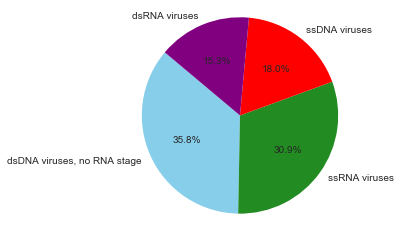

In [40]:
# Take a quick look at the distribution of these 4 classifications

# Turn classifications and their counts into lists
classifications_0 = [item[0] for item in list(genomes_0['Classification'].value_counts().items())]
class_counts_0 = [item[1] for item in list(genomes_0['Classification'].value_counts().items())]

#Plot the pie
plt.pie(class_counts_0, labels=classifications_0, colors=['skyblue', 'forestgreen', 'red', 'purple'],
        autopct='%1.1f%%', startangle=140)
plt.axis('equal')
None

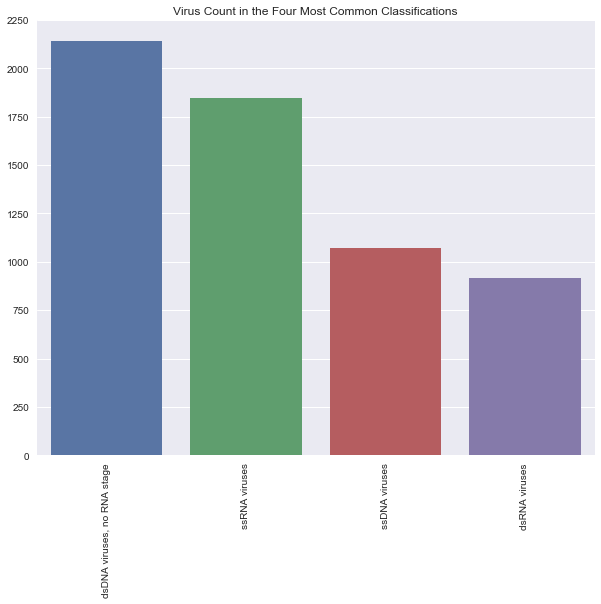

In [33]:
plt.figure(figsize = (10,8))
class_count_bar = sns.barplot(classifications_0, class_counts_0)
for item in class_count_bar.get_xticklabels():
    item.set_rotation(90)
plt.title('Virus Count in the Four Most Common Classifications')
None

In [ ]:
X0 = genomes_0['Sequence']
X0 = pad_seq_series(X0)
X0 = encode_seq_series(X0)
y0 = to_categorical(genomes_0['target'])
X0

In [ ]:
# Creating and saving arrays in EC2

In [ ]:
# Set up the target variable and train_test_split, with an equal proportion of target variables in test/train
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size = 0.33, stratify = y0)

# Reshape the input variables to make them 3D
X0_train = X0_train.reshape(X0_train.shape[0],1,len(X0[0]),1)
X0_test = X0_test.reshape(X0_test.shape[0],1,len(X0[0]),1)

# Check the shape
X0_train.shape

In [ ]:
# CNN to classify ssDNA viruses (1)
model_0 = Sequential()
model_0.add(Conv2D(50, kernel_size =(1,100), input_shape=(X0_train.shape[1:]), activation='relu'))
model_0.add(MaxPool2D((1, 5)))
model_0.add(Conv2D(40, (1,100), activation='relu'))
model_0.add(MaxPool2D((1, 4)))
model_0.add(Conv2D(30, (1,100), activation='relu'))
model_0.add(MaxPool2D((1, 3)))
model_0.add(Conv2D(20, (1,100), activation='relu'))
model_0.add(MaxPool2D((1, 2)))
model_0.add(Flatten())
model_0.add(Dense(50, activation='relu'))
model_0.add(Dense(y0.shape[1], activation='sigmoid'))

model_0.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_0.fit(X5_train, y5_train, validation_data = (X5_test, y5_test), epochs = 2)